<a href="https://colab.research.google.com/github/hlxabcd/hlxabcd.github.io/blob/master/sketcher/Sketcher_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

# Get the Class names 

In [27]:
!wget 'https://raw.githubusercontent.com/hlxabcd/hlxabcd.github.io/master/sketcher/class_names.txt'

--2019-03-20 11:26:13--  https://raw.githubusercontent.com/hlxabcd/hlxabcd.github.io/master/sketcher/class_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2790 (2.7K) [text/plain]
Saving to: ‘class_names.txt.2’

class_names.txt.2   100%[===================>]   2.72K  --.-KB/s    in 0s      

2019-03-20 11:26:13 (36.4 MB/s) - ‘class_names.txt.2’ saved [2790/2790]



Read the classes names 

In [0]:
f = open("class_names.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [30]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import urllib.request
import os
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    if not os.path.exists('data/' + c + '.npy'):
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [32]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ambulance.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/animal%20migration.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/arm.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/asparagus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/backpack.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/

# Imports 

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# 分割npy库提高加载效率

In [0]:
def split_dataset(root,target,max_items_per_class= 1000 ):
     all_files = glob.glob(os.path.join(root, '*.npy'))
     for idx, file in enumerate(all_files):
        print("process npy:",idx,file)
        data = np.load(file)
        # npy长度
        dataset_len = len(data)
        start = 0
        end = max_items_per_class
        num = 1
        fileName = file.split('/')[1].split('.')[0]
        # 按max_items_per_class分割npy文件
        while (start < dataset_len):
            resultData = data[start: end, :]
            # 分割后的文件命名
            targetFile = os.path.join(target, fileName+'_'+str(num)+'.npy');
            if not os.path.exists(targetFile):
              np.save(targetFile, resultData)
            num+=1
            start+=max_items_per_class
            end+=max_items_per_class


In [0]:
# # 分割npy
# !mkdir data_process2
# split_dataset('data','data_process2')

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
# import numpy as np
# data = np.load('data/aircraft_carrier.npy')
# print(data.shape)
# max_items_per_class = 10
# data = data[0: max_items_per_class, :]
# print(data)
# labels = np.full(data.shape[0], 1)

# x = np.empty([0, 784])
# x = np.concatenate((x, data), axis=0)

# image_size=28

# print(x)

# x = x.reshape(x.shape[0], image_size, image_size, 1)
# print(x)
# # x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')/255.0


In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 2000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        print(idx,file)
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

import time
import datetime


  
def load_data_process(root, data_process_num, vfold_ratio=0.2):
    all_files = glob.glob(os.path.join(root, '*_'+str(data_process_num)+'.npy'))

    #initialize variables 
    max_items_per_class = 1000
    x = np.zeros([max_items_per_class * len(all_files), 784])
#     x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []
    print("allfile:",len(all_files))
    #load each data file 
    for idx, file in enumerate(all_files):
#         print(idx,file)
        t = time.time()
        data = np.load(file)
#         a = time.time()-t
#         print('a:',a)
        labels = np.full(data.shape[0], idx)
        x[idx * max_items_per_class:(idx + 1) * max_items_per_class] = data
#         x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
#         b = time.time()-t
#         print('b:',b)
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

#         c = time.time()-t
#         print('c:',c)
        
    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
# class数量
num_classes=345
image_size = 28

# 准备model

allfile: 345
underwear_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 576)           

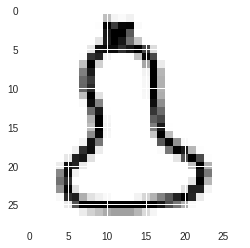

In [57]:
#x_train, y_train, x_test, y_test, class_names = load_data('data')
#num_classes = len(class_names)
#print(len(x_train))
data_process_count=20
count=1
while(count<=data_process_count):
  # load
  x_train, y_train, x_test, y_test, class_names = load_data_process('data_process2',count)
  num_classes = len(class_names)

  # show random data
  import matplotlib.pyplot as plt
  from random import randint
  %matplotlib inline  
  idx = randint(0, len(x_train))
  plt.imshow(x_train[idx].reshape(28,28)) 
  print(class_names[int(y_train[idx].item())])
    
  # Reshape and normalize
  x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')/255.0
  x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')/255.0

  # Convert class vectors to class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  if count==1:
  # Define model
    model = keras.Sequential()
    model.add(layers.Convolution2D(16, (3, 3),
                            padding='same',
                            input_shape=x_train.shape[1:], activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
    model.add(layers.MaxPooling2D(pool_size =(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax')) 
    # Train model
    adam = tf.train.AdamOptimizer()
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['top_k_categorical_accuracy'])
    print(model.summary())
  
  model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
  count+=1


# Training 

In [58]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 248400 samples, validate on 27600 samples
Epoch 1/5
 - 12s - loss: 2.2227 - top_k_categorical_accuracy: 0.7584 - val_loss: 2.2714 - val_top_k_categorical_accuracy: 0.7492
Epoch 2/5
 - 12s - loss: 2.1443 - top_k_categorical_accuracy: 0.7704 - val_loss: 2.2254 - val_top_k_categorical_accuracy: 0.7567
Epoch 3/5
 - 12s - loss: 2.0830 - top_k_categorical_accuracy: 0.7795 - val_loss: 2.1819 - val_top_k_categorical_accuracy: 0.7643
Epoch 4/5
 - 12s - loss: 2.0316 - top_k_categorical_accuracy: 0.7877 - val_loss: 2.1486 - val_top_k_categorical_accuracy: 0.7679
Epoch 5/5
 - 12s - loss: 1.9865 - top_k_categorical_accuracy: 0.7942 - val_loss: 2.1185 - val_top_k_categorical_accuracy: 0.7729


# Testing 

In [59]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 77.66%


# Inference 

['snorkel_20', 'beard_20', 'radio_20', 'hockey_puck_20', 'grapes_20']


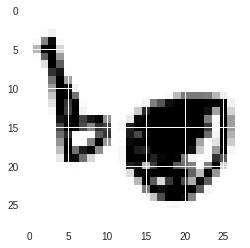

In [60]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [62]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 80.2MB 339kB/s 
    100% |████████████████████████████████| 13.9MB 293kB/s 
    100% |████████████████████████████████| 3.0MB 6.5MB/s 
    100% |████████████████████████████████| 358kB 9.7MB/s 
    100% |████████████████████████████████| 61kB 21.5MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


# Save and Convert 

In [63]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [66]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/class_names.txt (deflated 57%)
  adding: model/model.json (deflated 85%)


In [0]:
from google.colab import files
files.download('model.zip')